# Bước 1: Import thư viện

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

from matplotlib.dates import YearLocator, DateFormatter, MonthLocator

# Bước 2: Đọc dữ liệu

In [81]:
# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Đọc dữ liệu từ file CSV
df = pd.read_excel('/content/drive/MyDrive/Predict/VN_index.xlsx')

# Hiển thị lại DataFrame sau khi xóa
print(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
            Ngày  Khối lượng  Lần cuối  Thay đổi (%)
0     2024-07-31   715124608   1251.51        0.5180
1     2024-07-30   647887808   1245.06       -0.1235
2     2024-07-29   496463200   1246.60        0.3615
3     2024-07-26   453711776   1242.11        0.7233
4     2024-07-25   474923616   1233.19       -0.4263
...          ...         ...       ...           ...
5370  2003-01-08       42500    179.79       -0.4650
5371  2003-01-07       67400    180.63       -0.6217
5372  2003-01-06       52400    181.76       -0.3454
5373  2003-01-03       48100    182.39       -0.5561
5374  2003-01-02       30300    183.41        0.0436

[5375 rows x 4 columns]


# Bước 3: Mô tả dữ liệu

In [82]:
#định dạng cấu trúc thời gian
df["Ngày"] = pd.to_datetime(df.Ngày, errors='coerce') # Use errors='coerce' to handle potential errors during conversion. If there is any data in "Ngày" column doesn't match format 'YYYY-MM-DD' will be convert to NaT
# If your original date format is indeed '%d/%m/%Y' then change to
#df["Ngày"] = pd.to_datetime(df.Ngày,format="%d/%m/%Y", errors='coerce') # Use errors='coerce' to handle potential errors during conversion

In [83]:
#kích thước dữ liệu
df.shape

(5375, 4)

In [84]:
#dữ liệu 5 dòng đầu
df.head()

,Ngày,Khối lượng,Lần cuối,Thay đổi (%)
0,2024-07-31,715124608,1251.51,0.5180
1,2024-07-30,647887808,1245.06,-0.1235
2,2024-07-29,496463200,1246.60,0.3615
3,2024-07-26,453711776,1242.11,0.7233
4,2024-07-25,474923616,1233.19,-0.4263


In [85]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5375 entries, 0 to 5374
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Ngày          5375 non-null   datetime64[ns]
 1   Khối lượng    5375 non-null   int64         
 2   Lần cuối      5375 non-null   float64       
 3   Thay đổi (%)  5375 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 168.1 KB


In [86]:
#mô tả bộ dữ liệu
df.describe()

,Ngày,Khối lượng,Lần cuối,Thay đổi (%)
count,5375,5.375000e+03,5375.000000,5375.000000
mean,2013-10-22 21:14:26.009302272,1.893469e+08,683.365626,0.045234
min,2003-01-02 00:00:00,2.321000e+04,130.900000,-6.674400
25%,2008-06-09 12:00:00,9.388245e+06,434.620000,-0.549050
50%,2013-10-22 00:00:00,7.455002e+07,578.380000,0.061300
75%,2019-03-18 12:00:00,1.789232e+08,976.280000,0.707650
max,2024-07-31 00:00:00,1.706017e+09,1528.570000,4.980100
std,NaN,2.808087e+08,346.013631,1.376674


# Bước 4: Tiền xử lý dữ liệu

Cột 'Lần cuối' không phải là chuỗi, bỏ qua bước thay thế dấu phẩy.


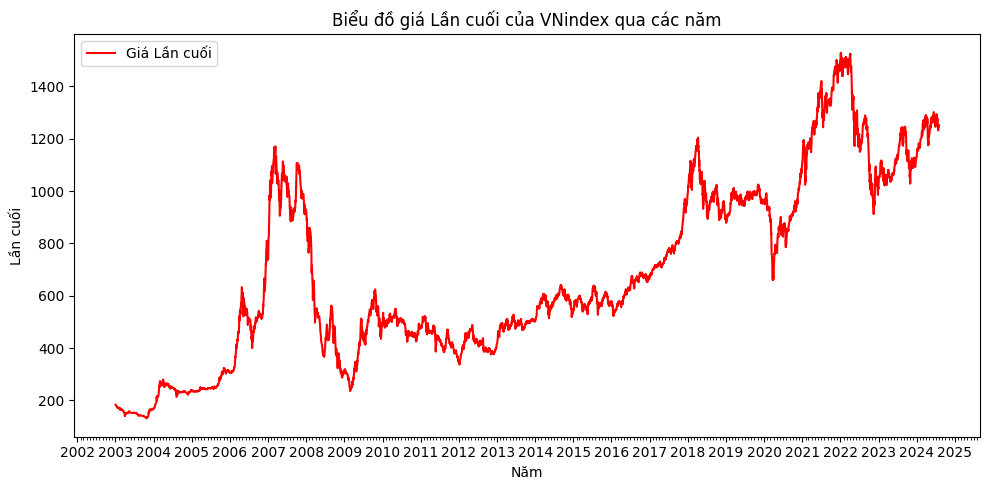

In [87]:
# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Chuyển đổi định dạng các cột giá thành số thực
# Kiểm tra xem cột 'Lần cuối' có phải là chuỗi không trước khi sử dụng .str
if df['Lần cuối'].dtype == object:  # object dtype thường đại diện cho chuỗi trong pandas
    df['Lần cuối'] = df['Lần cuối'].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

# Tạo đồ thị giá Lần cuối qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngày'], df['Lần cuối'], label='Giá Lần cuối', color='red')
plt.xlabel('Năm')
plt.ylabel('Lần cuối')
plt.title('Biểu đồ giá Lần cuối của VNindex qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()


In [88]:
df1 = pd.DataFrame(df,columns=['Ngày','Lần cuối'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1

,Lần cuối
Ngày,
2003-01-02,183.41
2003-01-03,182.39
2003-01-06,181.76
2003-01-07,180.63
2003-01-08,179.79
...,...
2024-07-25,1233.19
2024-07-26,1242.11
2024-07-29,1246.60


In [89]:
# Chuyển đổi DataFrame thành mảng NumPy
data = df1.values

# Xác định số lượng dòng của dữ liệu
split_index = len(data) // 2  # Chia đôi dữ liệu

# Chia tập dữ liệu thành 50% cho train và 50% cho test
train_data = data[:split_index]  # 50% đầu làm train
test_data = data[split_index:]   # 50% sau làm test

# Hiển thị kích thước của tập huấn luyện và tập kiểm tra
print("Train data size:", train_data.shape)
print("Test data size:", test_data.shape)

Train data size: (2687, 1)
Test data size: (2688, 1)


In [90]:
data

array([[ 183.41],
       [ 182.39],
       [ 181.76],
       ...,
       [1246.6 ],
       [1245.06],
       [1251.51]])

In [91]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [92]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá Lần cuối liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá Lần cuối ngày hôm sau

In [93]:
x_train

[array([0.03756967, 0.03683988, 0.03638913, 0.03558064, 0.03497964,
        0.03436433, 0.03417831, 0.03372041, 0.03320526, 0.03257564,
        0.03020026, 0.03015733, 0.0289768 , 0.02894818, 0.02836864,
        0.02942755, 0.0298783 , 0.02962073, 0.02967796, 0.02864768,
        0.02625083, 0.02361788, 0.02587878, 0.02706647, 0.02689476,
        0.02599326, 0.02533502, 0.02510607, 0.02412587, 0.02474118,
        0.02460524, 0.02419026, 0.02417595, 0.02411871, 0.02481272,
        0.02433335, 0.02392553, 0.0238826 , 0.02369658, 0.02337462,
        0.02286663, 0.02233002, 0.02198659, 0.02175048, 0.0213212 ,
        0.01926778, 0.01935364, 0.01805863, 0.0174147 , 0.01648458]),
 array([0.03683988, 0.03638913, 0.03558064, 0.03497964, 0.03436433,
        0.03417831, 0.03372041, 0.03320526, 0.03257564, 0.03020026,
        0.03015733, 0.0289768 , 0.02894818, 0.02836864, 0.02942755,
        0.0298783 , 0.02962073, 0.02967796, 0.02864768, 0.02625083,
        0.02361788, 0.02587878, 0.02706647, 0.

In [94]:
y_train

[0.015862113374401673,
 0.015354125079596756,
 0.015067934490974266,
 0.014044803136648853,
 0.01038156360228093,
 0.006253264361401459,
 0.010038134895933942,
 0.013078909900047939,
 0.013823005430466412,
 0.013229159959074727,
 0.011619337898073206,
 0.011154278191561673,
 0.01199138566328245,
 0.013143302782488,
 0.012964433664598943,
 0.012728326428985373,
 0.012792719311425435,
 0.014144969842666708,
 0.015218184550001054,
 0.015075089255689816,
 0.015067934490974266,
 0.015511529903339136,
 0.01579772049196161,
 0.015783410962530497,
 0.01563316090350368,
 0.015482910844476866,
 0.015246803608863324,
 0.01601951819814404,
 0.017114197199625078,
 0.017901221318336935,
 0.018366281024848483,
 0.019310709967302706,
 0.019775769673814267,
 0.018960126496240168,
 0.017722352200447877,
 0.017815364141750195,
 0.016656292257829095,
 0.016656292257829095,
 0.016656292257829095,
 0.015940815786272863,
 0.01604098249229073,
 0.015654625197650374,
 0.015497220373907994,
 0.01562600613878813

In [95]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

# Bước 5: Xây dựng và huấn luyện mô hình

In [96]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [97]:
#huấn luyện mô hình
save_model = "/content/drive/MyDrive/Predict/save_model.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.04586, saving model to /content/drive/MyDrive/Predict/save_model.keras
53/53 - 17s - 316ms/step - loss: 0.0459
Epoch 2/100

Epoch 2: loss improved from 0.04586 to 0.02917, saving model to /content/drive/MyDrive/Predict/save_model.keras
53/53 - 16s - 310ms/step - loss: 0.0292
Epoch 3/100

Epoch 3: loss improved from 0.02917 to 0.02759, saving model to /content/drive/MyDrive/Predict/save_model.keras
53/53 - 12s - 224ms/step - loss: 0.0276
Epoch 4/100

Epoch 4: loss improved from 0.02759 to 0.02522, saving model to /content/drive/MyDrive/Predict/save_model.keras
53/53 - 22s - 414ms/step - loss: 0.0252
Epoch 5/100

Epoch 5: loss did not improve from 0.02522
53/53 - 14s - 272ms/step - loss: 0.0263
Epoch 6/100

Epoch 6: loss improved from 0.02522 to 0.02329, saving model to /content/drive/MyDrive/Predict/save_model.keras
53/53 - 18s - 347ms/step - loss: 0.0233
Epoch 7/100

Epoch 7: loss improved from 0.02329 to 0.02236, saving model to /conte

In [98]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/Predict/save_model.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá Lần cuối trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


# Bước 6: Tái sử dụng mô hình

In [99]:
# Xử lý dữ liệu test, lấy từ split_index - 50 để đảm bảo đủ 50 điểm cho mỗi lần dự báo
test = df1[split_index-50:].values  # Lấy dữ liệu test từ vị trí giữa, trừ 50 giá trị
test = test.reshape(-1, 1)  # Định dạng lại thành mảng 2 chiều

# Chuẩn hóa dữ liệu test sử dụng scaler đã dùng cho train
sc_test = sc.transform(test)

# Tạo danh sách x_test, lấy mỗi 50 giá trị làm đầu vào
x_test = []
for i in range(50, test.shape[0]):  # Bắt đầu từ hàng thứ 50 để đảm bảo đủ dữ liệu
    x_test.append(sc_test[i-50:i, 0])  # Lấy 50 giá trị trước đó

# Chuyển danh sách x_test thành mảng NumPy
x_test = np.array(x_test)

# Reshape x_test thành định dạng phù hợp cho mô hình LSTM (samples, timesteps, features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Dữ liệu y_test: giá thực tế từ split_index trở đi (tương ứng với phần test của dữ liệu)
y_test = data[split_index:]  # Giá thực tế (từ 50% dữ liệu trở đi)

# Dự đoán giá trị y_test từ mô hình đã huấn luyện
y_test_predict = final_model.predict(x_test)

# Đảo chuẩn hóa giá trị dự đoán để trả về giá trị ban đầu
y_test_predict = sc.inverse_transform(y_test_predict)

# Hiển thị một số giá trị để kiểm tra
print("Giá thực tế (y_test):", y_test[:5])
print("Giá dự đoán (y_test_predict):", y_test_predict[:5])


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Giá thực tế (y_test): [[500.57]
 [504.05]
 [501.17]
 [500.75]
 [496.46]]
Giá dự đoán (y_test_predict): [[495.68054]
 [494.75647]
 [497.99152]
 [495.45093]
 [494.7796 ]]


# Độ chính xác của mô hình

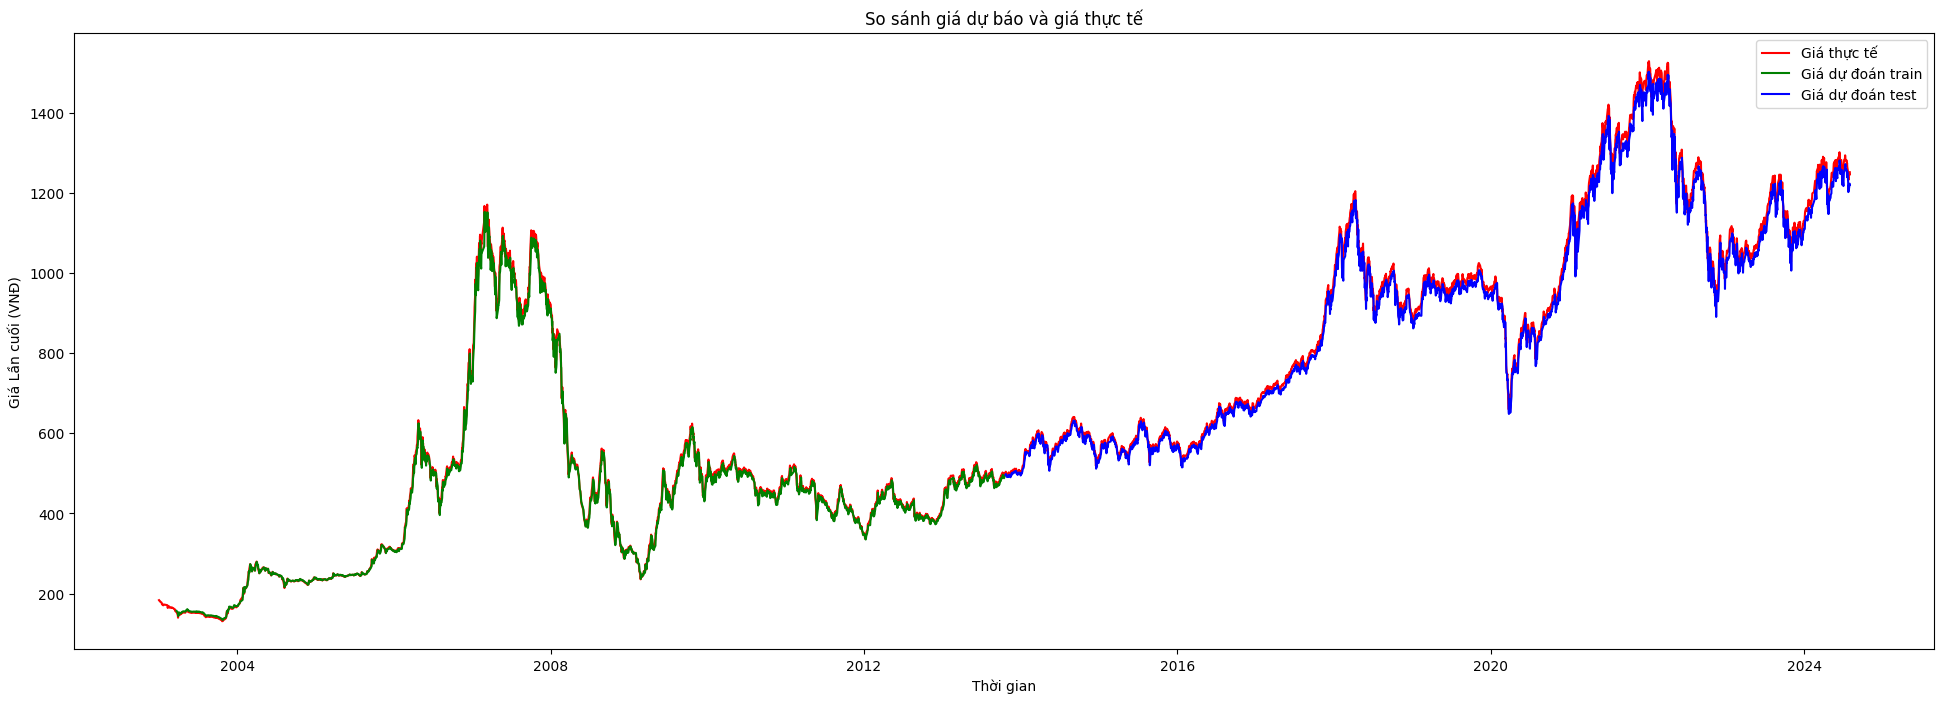

In [100]:
# Tính toán split_index dựa trên độ dài của y_test
split_index = len(df1) - len(y_test)

# Chia df1 để phù hợp với kích thước của y_train và y_test
train_data1 = df1[:split_index].copy()  # Dữ liệu trước split_index cho visual train
test_data1 = df1[split_index:].copy()   # Dữ liệu từ split_index trở đi cho visual test

# Thêm cột 'Dự đoán' vào train_data1 và test_data1
train_data1['Dự đoán'] = np.nan  # Để các giá trị mặc định là NaN
test_data1['Dự đoán'] = np.nan

# Điều chỉnh lại kích thước của y_train_predict cho khớp với phần dữ liệu train
y_train_predict_adjusted = y_train_predict[-(len(train_data1) - 50):]  # Cắt đúng số lượng dự đoán cho phần train

# Gán giá trị dự đoán vào các phần tương ứng của DataFrame
train_data1.iloc[50:, train_data1.columns.get_loc('Dự đoán')] = y_train_predict_adjusted  # Thêm dữ liệu dự đoán train từ vị trí thứ 50
test_data1['Dự đoán'] = y_test_predict  # Thêm dữ liệu dự đoán test

# Vẽ biểu đồ so sánh
plt.figure(figsize=(24, 8))
plt.plot(df1.index, df1.values, label='Giá thực tế', color='red')  # Đường giá thực

# Vẽ đường dự đoán train
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')

# Vẽ đường dự đoán test
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')

# Đặt tiêu đề và nhãn
plt.title('So sánh giá dự báo và giá thực tế')  # Đặt tên biểu đồ
plt.xlabel('Thời gian')  # Đặt tên trục X
plt.ylabel('Giá Lần cuối (VNĐ)')  # Đặt tên trục Y
plt.legend()  # Chú thích

# Hiển thị biểu đồ
plt.show()


In [101]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9975327036097427
Sai số tuyệt đối trung bình trên tập train (VNĐ): 7.438145692237278
Phần trăm sai số tuyệt đối trung bình tập train: 0.015243096194673475


In [102]:
train_data1

,Lần cuối,Dự đoán
Ngày,,
2003-01-02,183.41,NaN
2003-01-03,182.39,NaN
2003-01-06,181.76,NaN
2003-01-07,180.63,NaN
2003-01-08,179.79,NaN
...,...,...
2013-10-15,495.72,487.872070
2013-10-16,498.96,489.686340
2013-10-17,499.59,492.884460


In [103]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9941390758903792
Sai số tuyệt đối trung bình trên tập test (VNĐ): 17.492485036849974
Phần trăm sai số tuyệt đối trung bình tập test: 0.018245094663305803


In [104]:
test_data1

,Lần cuối,Dự đoán
Ngày,,
2013-10-22,500.57,495.680542
2013-10-23,504.05,494.756470
2013-10-24,501.17,497.991516
2013-10-25,500.75,495.450928
2013-10-28,496.46,494.779602
...,...,...
2024-07-25,1233.19,1218.520142
2024-07-26,1242.11,1206.461426
2024-07-29,1246.60,1220.498901


# Dự đoán giá tương lai và so sánh với giá ngày cuối

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


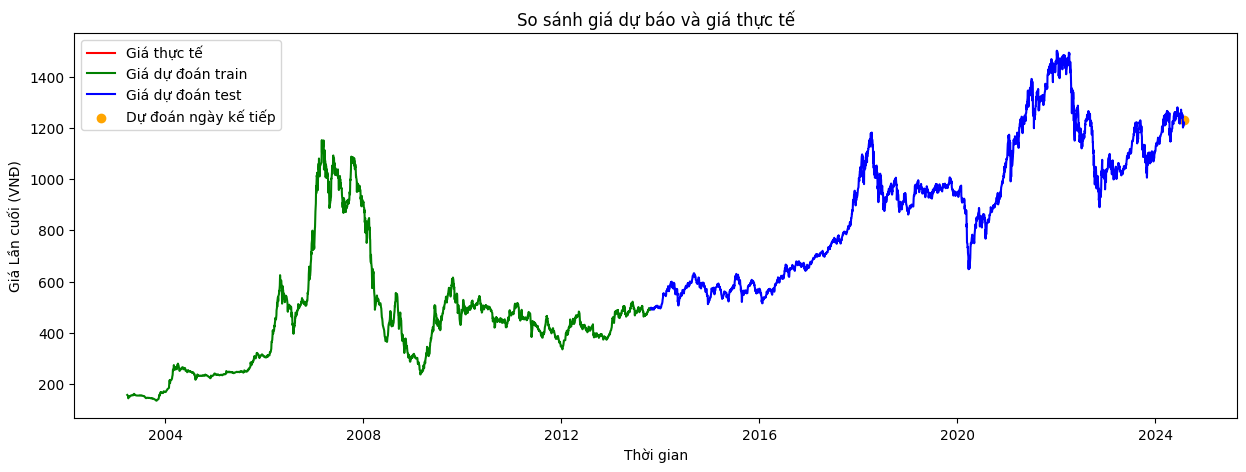

In [105]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Lần cuối'].iloc[-1]])  # Lấy giá trị Lần cuối của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá Lần cuối gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Ngày': [next_date], 'Lần cuối': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Ngày'], df1['Lần cuối'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá Lần cuối (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


In [106]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Lần cuối'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

        Ngày  Giá dự đoán  Giá ngày trước
0 2024-08-01  1229.714355         1251.51
